# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




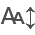

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag16vva57r0v2dln.allegrograph.cloud/repositories/nobel-laureats"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

770


[['http://www.wikidata.org/entity/Q202140',
  'Robert H. Grubbs',
  '1942',
  'male',
  'United States',
  'North America',
  'autobiographer, university teacher, chemist',
  'organic chemistry, chemistry'],
 ['http://www.wikidata.org/entity/Q233943',
  'Albert Claude',
  '1899',
  'male',
  'Belgium, United States',
  'Europe, North America',
  'cell biologist, academic, biochemist, university teacher, biologist, chemist, physician',
  'biochemistry'],
 ['http://www.wikidata.org/entity/Q60429',
  'Chandrasekhara Venkata Raman',
  '1888',
  'male',
  'India',
  'Asia',
  'crystallographer, university teacher, physicist',
  'physics']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry"
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics
3,http://www.wikidata.org/entity/Q169366,Carl David Anderson,1905,male,United States,North America,"university teacher, physicist","particle physics, physics"
4,http://www.wikidata.org/entity/Q1403,Luigi Pirandello,1867,male,Kingdom of Italy,Europe,"novelist, playwright, director, writer, screen...",


In [9]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [10]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    770 non-null    object
 1   personLabel  770 non-null    object
 2   birthYear    770 non-null    int64 
 3   gender       770 non-null    object
 4   countries    770 non-null    object
 5   continents   770 non-null    object
 6   occupations  770 non-null    object
 7   fields       770 non-null    object
dtypes: int64(1), object(7)
memory usage: 48.3+ KB


In [11]:
### Store to CSV
f_path = 'df_continent_occupations_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [12]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0            North America
1    Europe, North America
2                     Asia
3            North America
4                   Europe
Name: continents, dtype: object


In [13]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                  0
continents                         
Europe                          336
North America                   246
Europe, North America            69
Asia                             32
Oceania                           9
Asia, Europe                      8
Asia, North America               7
North America, Europe             7
North America, Asia               7
North America, Eurasia, Europe    6


In [14]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [15]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [16]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics,Asia


In [17]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
SouthAmerica         4
Eurasia              6
Africa               7
Oceania             12
Asia                32
NorthAmerica       261
Europe             448


In [18]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
37,http://www.wikidata.org/entity/Q104668,Vitaly Ginzburg,1916,male,"Soviet Union, Russia","Asia, Europe","theoretical physicist, university teacher, ast...","physics, astrophysics, theoretical physics",Europe
71,http://www.wikidata.org/entity/Q121180,Q121180,1867,male,"Second Polish Republic, Russian Empire","Europe, North America, Eurasia","prose writer, novelist, screenwriter, writer",fiction,Europe
186,http://www.wikidata.org/entity/Q7186,Marie Curie,1867,female,"Russian Empire, France, Second Polish Republic","North America, Eurasia, Europe","university teacher, chemist, physicist","polonium, radium, physics, chemistry, radioact...",Europe
195,http://www.wikidata.org/entity/Q183279,Zhores Alferov,1930,male,"Soviet Union, Russia","Asia, Europe","physicist, inventor, politician, member of the...","semiconductor physics, physics, semiconductor,...",Europe
212,http://www.wikidata.org/entity/Q48990,Nikolay Semyonov,1896,male,"Russian Empire, Soviet Union","North America, Eurasia, Asia, Europe","chemist, physicist, professor, politician",chemical physics,Europe
224,http://www.wikidata.org/entity/Q133267,Lev Landau,1908,male,"Azerbaijan Democratic Republic, Soviet Union, ...","Europe, Asia, North America, Eurasia","theoretical physicist, non-fiction writer, uni...",theoretical physics,Eurasia
235,http://www.wikidata.org/entity/Q12658,Wilhelm Ostwald,1853,male,"Russian Empire, Germany","North America, Eurasia, Europe","teacher, writer, philosopher, university teach...",physical chemistry,Europe


In [19]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia          2
Europe          32


In [20]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q232024,John James Rickard Macleod,1876,male,United Kingdom,Europe,"university teacher, physiologist, inventor, ph...","medicine, physiology",Europe
98,http://www.wikidata.org/entity/Q157701,Jaroslav Heyrovský,1890,male,Czechoslovakia,Europe,"chemist, physicist, inventor, teacher, scientist","discoveries and inventions, polarography, phys...",Europe
99,http://www.wikidata.org/entity/Q81218,John Gurdon,1933,male,United Kingdom,Europe,"university teacher, biologist, physician",developmental biology,Europe
100,http://www.wikidata.org/entity/Q254032,Olga Tokarczuk,1962,female,Poland,Europe,"donor, writer, screenwriter, poet, psychologis...",,Europe


In [21]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q171034,Robert Wilson,1936,male,United States,North America,"researcher, physicist, astronomer",physics,NorthAmerica
112,http://www.wikidata.org/entity/Q186391,Theodor Svedberg,1884,male,Sweden,Europe,"university teacher, chemist, artist",biochemistry,Europe
113,http://www.wikidata.org/entity/Q47619,Nadine Gordimer,1923,female,South Africa,Africa,"poet, writer, short story writer, prose writer...",literature,Africa
114,http://www.wikidata.org/entity/Q83059,Saul Bellow,1915,male,United States,North America,"essayist, novelist, university teacher, writer...",novel,NorthAmerica
115,http://www.wikidata.org/entity/Q106949,Saul Perlmutter,1959,male,United States,North America,"researcher, astrophysicist, physicist, profess...",astrophysics,NorthAmerica
116,http://www.wikidata.org/entity/Q156480,Hugo Theorell,1903,male,Sweden,Europe,"biochemist, university teacher, physician",biochemistry,Europe
117,http://www.wikidata.org/entity/Q107609,Christiaan Eijkman,1858,male,Kingdom of the Netherlands,Europe,"biochemist, university teacher, physiologist, ...",pathology,Europe


In [22]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  461 

0    http://www.wikidata.org/entity/Q202140
1    http://www.wikidata.org/entity/Q233943
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe
4,http://www.wikidata.org/entity/Q1403,Luigi Pirandello,1867,male,Kingdom of Italy,Europe,"novelist, playwright, director, writer, screen...",,Europe
8,http://www.wikidata.org/entity/Q108896,Hamilton Smith,1931,male,United States,North America,"microbiologist, biochemist, biologist, biotech...","molecular biology, microbiology",NorthAmerica
10,http://www.wikidata.org/entity/Q1929672,Michael W. Young,1949,male,United States,North America,"geneticist, university teacher, chronobiologist",chronobiology,NorthAmerica


### Distribution des continents: représentation graphique

In [23]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
SouthAmerica,4,0.52
Eurasia,6,0.78
Africa,7,0.91
Oceania,12,1.56
Asia,32,4.16
NorthAmerica,261,33.90
Europe,448,58.18


In [24]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Asia,Oceania,Africa,Eurasia,SouthAmerica
frequence,58.18,33.9,4.16,1.56,0.91,0.78,0.52


In [25]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


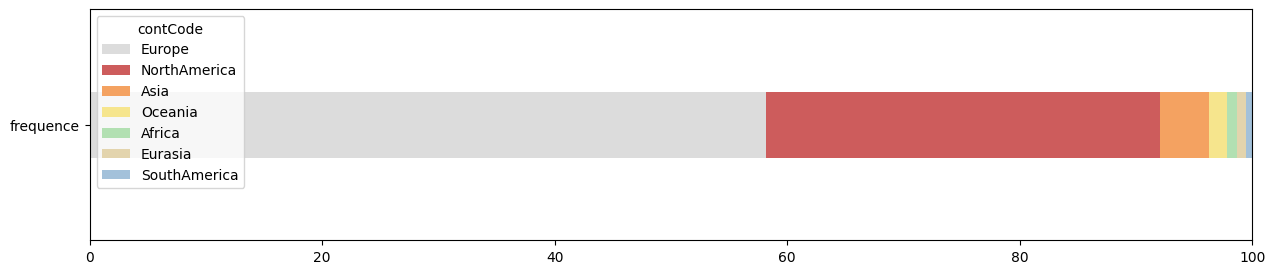

In [26]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [27]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [28]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [29]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics,Asia,1876-1900


In [30]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1801-1825      1
1826-1850     24
1851-1875     88
1876-1900    129
1901-1925    215
1926-1950    245
1951-1975     66
1976-2000      2
dtype: int64


### Comparer période et continent

In [31]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1801-1825,0,0,0,1,0,0,0,1
1826-1850,0,0,0,24,0,0,0,24
1851-1875,0,1,0,81,5,1,0,88
1876-1900,1,2,2,92,28,2,2,129
1901-1925,3,4,2,115,87,3,1,215
1926-1950,3,18,1,109,109,4,1,245
1951-1975,0,7,1,25,31,2,0,66
1976-2000,0,0,0,1,1,0,0,2
Total,7,32,6,448,261,12,4,770


In [32]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1801-1825,1,0,0,0,0,0,0,1
1826-1850,24,0,0,0,0,0,0,24
1851-1875,81,0,5,1,0,1,0,88
1876-1900,92,2,28,2,1,2,2,129
1901-1925,115,2,87,4,3,3,1,215
1926-1950,109,1,109,18,3,4,1,245
1951-1975,25,1,31,7,0,2,0,66
1976-2000,1,0,1,0,0,0,0,2
Total,448,6,261,32,7,12,4,770


In [33]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


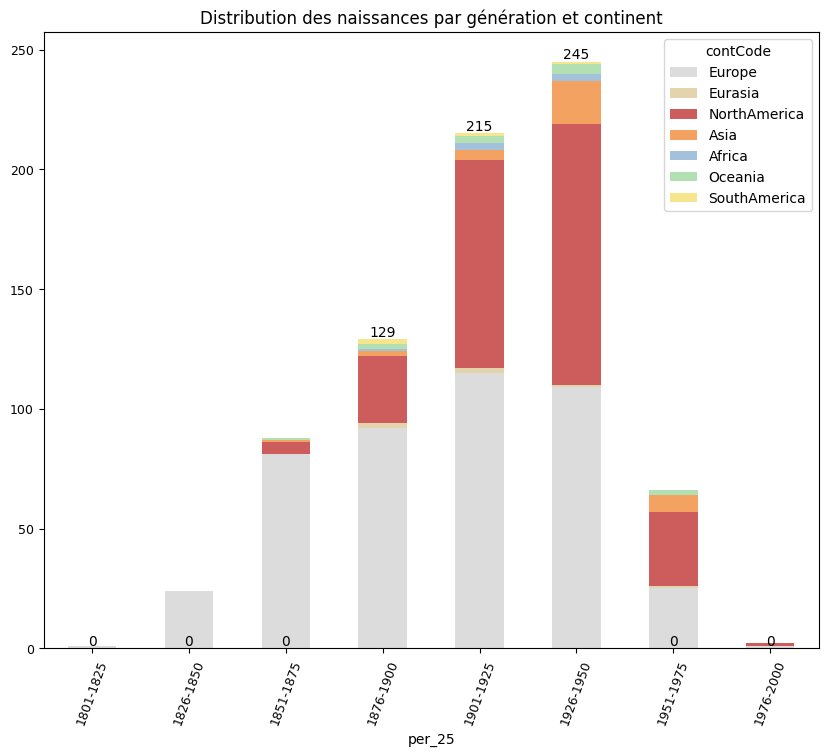

In [34]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [35]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1801-1825,1,0,0,0,0,0,0,1
1826-1850,24,0,0,0,0,0,0,24
1851-1875,81,0,5,1,0,1,0,88
1876-1900,92,2,28,2,1,2,2,129
1901-1925,115,2,87,4,3,3,1,215
1926-1950,109,1,109,18,3,4,1,245
1951-1975,25,1,31,7,0,2,0,66
1976-2000,1,0,1,0,0,0,0,2
Total,448,6,261,32,7,12,4,770


In [36]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1876-1900,92,2,28,2,1,2,2
1901-1925,115,2,87,4,3,3,1
1926-1950,109,1,109,18,3,4,1
1951-1975,25,1,31,7,0,2,0
1976-2000,1,0,1,0,0,0,0
Total,448,6,261,32,7,12,4


In [37]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 6 , 7 ), effectif: 1427 , nombre max. facteurs: 5


In [38]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 55.66 , dof : 30
p-value : 0.002986312483929516
phi2 = inertie (variance totale) : 0.039005089835490864
Cramer:  0.08832337157909095


In [39]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1876-1900,71,1,47,6,1,2,1
1901-1925,119,2,78,9,2,3,1
1926-1950,136,2,89,11,2,4,1
1951-1975,37,1,24,3,1,1,0
1976-2000,1,0,1,0,0,0,0
Total,426,6,279,34,8,12,4


In [40]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1876-1900,92,2,28,2,1,2,2
1901-1925,115,2,87,4,3,3,1
1926-1950,109,1,109,18,3,4,1
1951-1975,25,1,31,7,0,2,0
1976-2000,1,0,1,0,0,0,0
Total,448,6,261,32,7,12,4


In [41]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1876-1900      21        1           -19    -4       0        0             1
1901-1925      -4        0             9    -5       1        0             0
1926-1950     -27       -1            20     7       1        0             0
1951-1975     -12        0             7     4      -1        1             0
1976-2000       0        0             0     0       0        0             0
Total          22        0           -18    -2      -1        0             0


In [42]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1876-1900,2.44,0.88,-2.74,-1.55,-0.24,-0.05,1.50
1901-1925,-0.37,0.14,1.03,-1.78,0.61,-0.25,-0.19
1926-1950,-2.29,-0.74,2.15,2.18,0.38,0.03,-0.32
1951-1975,-1.91,0.60,1.45,2.39,-0.80,0.91,-0.61
1976-2000,-0.10,-0.13,0.32,-0.30,-0.14,-0.18,-0.11
Total,1.05,-0.19,-1.08,-0.34,-0.20,-0.12,-0.15


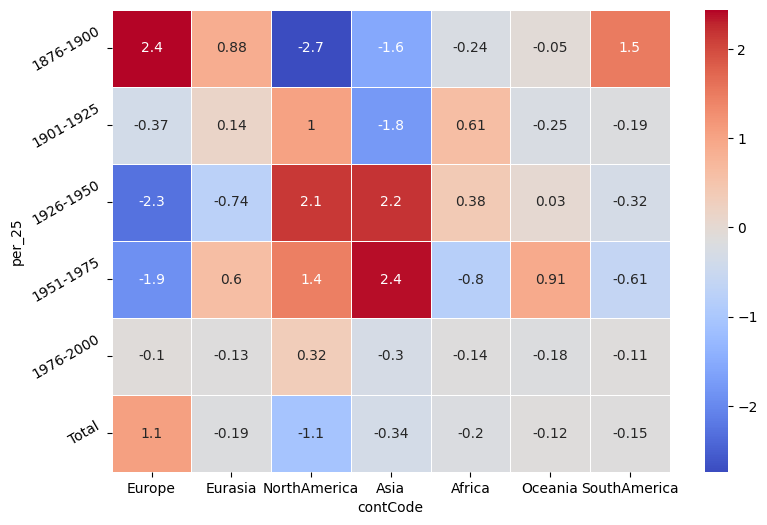

In [43]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [44]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1876-1900,2,28,2,1,2,2
1901-1925,2,87,4,3,3,1
1926-1950,1,109,18,3,4,1
1951-1975,1,31,7,0,2,0
1976-2000,0,1,0,0,0,0
Total,6,261,32,7,12,4


In [45]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 20.33 , dof : 25
p-value : 0.7291665870204271
phi2 = inertie (variance totale) : 0.014248513080939098
Cramer:  0.07989912825505918


In [46]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1876-1900,92,2,2,28,2
1901-1925,115,4,2,87,1
1926-1950,109,18,1,109,1
1951-1975,25,7,1,31,0
1976-2000,1,0,0,1,0
Total,448,32,6,261,4


In [47]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 1.63 , dof : 5
p-value : 0.8974847972411402
phi2 = inertie (variance totale) : 0.0011429031538052394
Cramer:  0.045095116993511056


## Continent et genre

In [48]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics,Asia,1876-1900
3,http://www.wikidata.org/entity/Q169366,Carl David Anderson,1905,male,United States,North America,"university teacher, physicist","particle physics, physics",NorthAmerica,1901-1925
4,http://www.wikidata.org/entity/Q1403,Luigi Pirandello,1867,male,Kingdom of Italy,Europe,"novelist, playwright, director, writer, screen...",,Europe,1851-1875


In [49]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,1,3,1,22,14,1,1,43
male,6,29,5,426,247,11,3,727
Total,7,32,6,448,261,12,4,770


### Créer la fonction

In [50]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [51]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,1,3,1,22,14,1,1
male,6,29,5,426,247,11,3


Chi2 : 6.72 , dof : 6
p-value : 0.34787738078816377
phi2 = inertie (variance totale) : 0.004706621601415383
Cramer:  0.09339449235144487


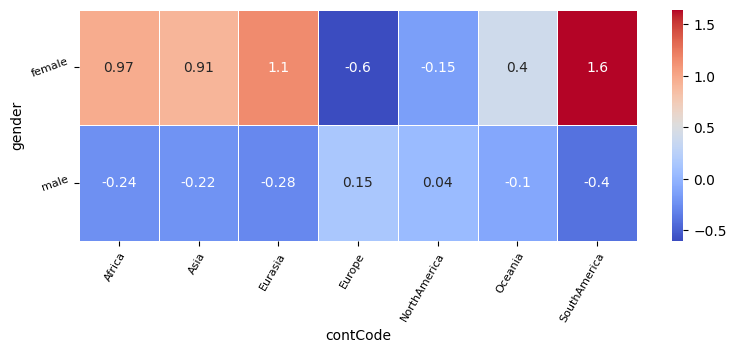

In [52]:
bivariee_stats(D)

### Genre et continent par époque

In [53]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950,NorthAmerica_male
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900,Europe_male
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics,Asia,1876-1900,Asia_male
3,http://www.wikidata.org/entity/Q169366,Carl David Anderson,1905,male,United States,North America,"university teacher, physicist","particle physics, physics",NorthAmerica,1901-1925,NorthAmerica_male
4,http://www.wikidata.org/entity/Q1403,Luigi Pirandello,1867,male,Kingdom of Italy,Europe,"novelist, playwright, director, writer, screen...",,Europe,1851-1875,Europe_male


In [54]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1801-1825,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1826-1850,0,0,0,0,0,0,0,24,0,0,0,0,0,0,24
1851-1875,0,0,0,1,0,0,3,78,0,5,0,1,0,0,88
1876-1900,0,1,0,2,0,2,4,88,1,27,0,2,1,1,129
1901-1925,1,2,0,4,0,2,5,110,3,84,0,3,0,1,215
1926-1950,0,3,2,16,1,0,4,105,4,105,1,3,0,1,245
1951-1975,0,0,1,6,0,1,6,19,6,25,0,2,0,0,66
1976-2000,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2
Total,1,6,3,29,1,5,22,426,14,247,1,11,1,3,770


In [55]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[6:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1951-1975,0,0,1,6,0,1,6,19,6,25,0,2,0,0
1976-2000,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [58]:
# Select rows from '1876-1900' to '1926-1950' (inclusive)
D_filtered = ddgcp.loc['1876-1900':'1926-1950'].copy()

# Combine genders for Europe and North America
D_filtered['Europe'] = D_filtered['Europe_female'] + D_filtered['Europe_male']
D_filtered['NorthAmerica'] = D_filtered['NorthAmerica_female'] + D_filtered['NorthAmerica_male']

# Sum all other regions (Africa, Asia, Eurasia, Oceania, South America) with combined genders
other_regions = [
    'Africa_female', 'Africa_male',
    'Asia_female', 'Asia_male',
    'Eurasia_female', 'Eurasia_male',
    'Oceania_female', 'Oceania_male',
    'SouthAmerica_female', 'SouthAmerica_male'
]
D_filtered['Other'] = D_filtered[other_regions].sum(axis=1)

# Keep only the combined columns (Europe, NorthAmerica, Other)
D_filtered = D_filtered[['Europe', 'NorthAmerica', 'Other']]

# Display the result
D_filtered

genre_cont,Europe,NorthAmerica,Other
per_25,,,
1876-1900,92,28,9
1901-1925,115,87,13
1926-1950,109,109,27


Chi2 : 27.16 , dof : 4
p-value : 1.8413152018187316e-05
phi2 = inertie (variance totale) : 0.0190360903016898
Cramer:  0.15185469347085317


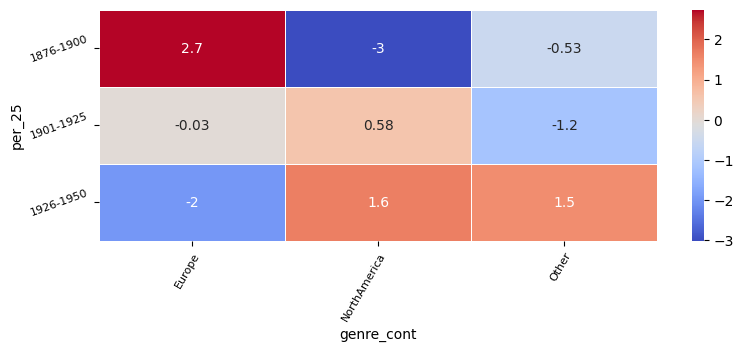

In [59]:
## Appliquer la fonction
bivariee_stats(D_filtered)

#### Explorer les résultats et commenter

In [60]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

22


In [63]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
France                                         4
Poland                                         2
Norway                                         2
Austria                                        1
Czechoslovakia, Cisleithania, United States    1
Germany, Sweden                                1
Germany, United States                         1
France, Sweden                                 1
Germany                                        1
Kingdom of Italy                               1
dtype: int64


In [66]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

Series([], dtype: int64)


In [67]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

0


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont


## Continent et discipline

In [62]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950,NorthAmerica_male
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900,Europe_male
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics,Asia,1876-1900,Asia_male
3,http://www.wikidata.org/entity/Q169366,Carl David Anderson,1905,male,United States,North America,"university teacher, physicist","particle physics, physics",NorthAmerica,1901-1925,NorthAmerica_male
4,http://www.wikidata.org/entity/Q1403,Luigi Pirandello,1867,male,Kingdom of Italy,Europe,"novelist, playwright, director, writer, screen...",,Europe,1851-1875,Europe_male


In [68]:
def code_discipline(col1, col2):
    if  'biochemist' in col1\
        or 'biochemistry' in col2:
        output = 'biochemistry'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [69]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950,NorthAmerica_male,other
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900,Europe_male,biochemistry
2,http://www.wikidata.org/entity/Q60429,Chandrasekhara Venkata Raman,1888,male,India,Asia,"crystallographer, university teacher, physicist",physics,Asia,1876-1900,Asia_male,physics
3,http://www.wikidata.org/entity/Q169366,Carl David Anderson,1905,male,United States,North America,"university teacher, physicist","particle physics, physics",NorthAmerica,1901-1925,NorthAmerica_male,physics
4,http://www.wikidata.org/entity/Q1403,Luigi Pirandello,1867,male,Kingdom of Italy,Europe,"novelist, playwright, director, writer, screen...",,Europe,1851-1875,Europe_male,other


In [70]:
df_p.groupby('code_discipline').size()

code_discipline
biochemistry    161
other           322
physics         287
dtype: int64

In [71]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
biochemistry,0,5,0,82,73,1,0,161
other,5,15,4,200,85,9,4,322
physics,2,12,2,166,103,2,0,287
Total,7,32,6,448,261,12,4,770


In [72]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
biochemistry,0.0,3.1,0.0,50.9,45.3,0.6,0.0,100.0
other,1.6,4.7,1.2,62.1,26.4,2.8,1.2,100.0
physics,0.7,4.2,0.7,57.8,35.9,0.7,0.0,100.0
Total,0.9,4.2,0.8,58.2,33.9,1.6,0.5,100.0


In [73]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


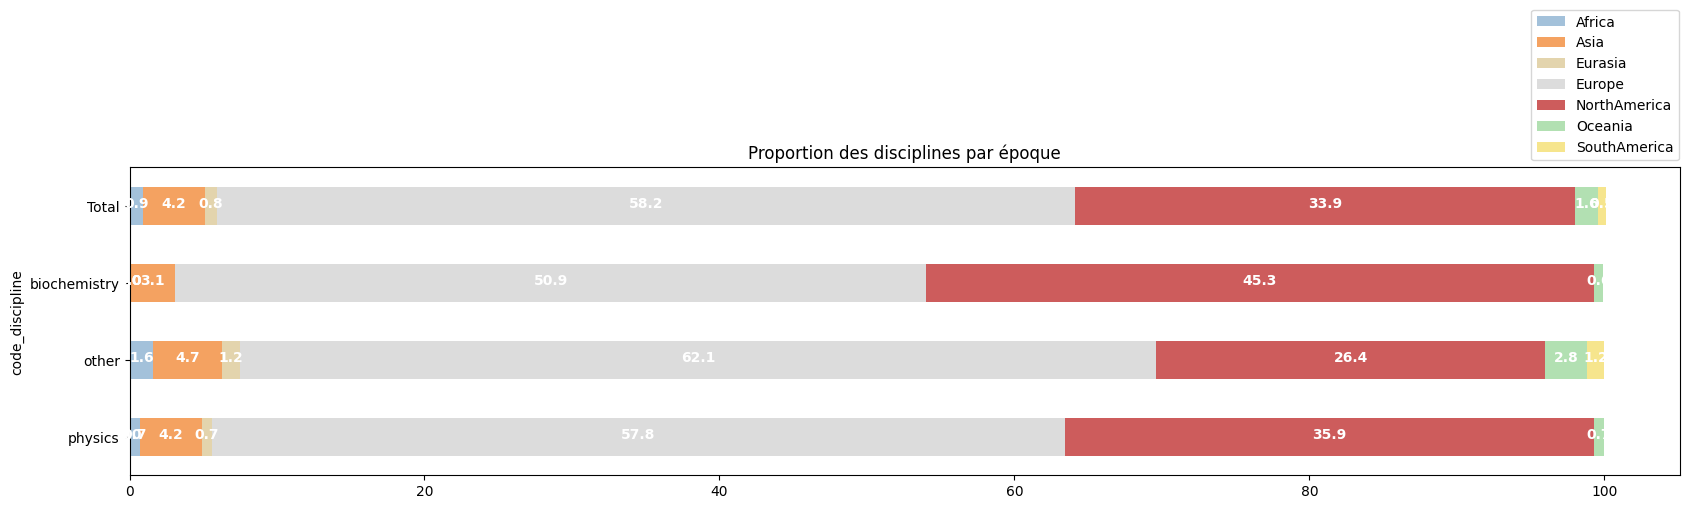

In [74]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [75]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
biochemistry,0,5,0,82,73,1,0
other,5,15,4,200,85,9,4
physics,2,12,2,166,103,2,0


Chi2 : 31.08 , dof : 12
p-value : 0.0019176469333561663
phi2 = inertie (variance totale) : 0.021777646845792916
Cramer:  0.14205518876535295


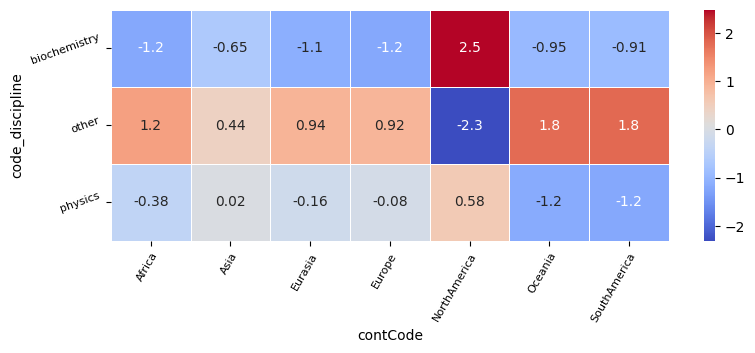

In [76]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [77]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950,NorthAmerica_male,other
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900,Europe_male,biochemistry


In [78]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q202140,Robert H. Grubbs,1942,male,United States,North America,"autobiographer, university teacher, chemist","organic chemistry, chemistry",NorthAmerica,1926-1950,NorthAmerica_male,other,NorthAmerica_other
1,http://www.wikidata.org/entity/Q233943,Albert Claude,1899,male,"Belgium, United States","Europe, North America","cell biologist, academic, biochemist, universi...",biochemistry,Europe,1876-1900,Europe_male,biochemistry,Europe_biochemistry


In [94]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_other,Africa_physics,Asia_biochemistry,Asia_other,Asia_physics,Eurasia_other,Eurasia_physics,Europe_biochemistry,Europe_other,Europe_physics,NorthAmerica_biochemistry,NorthAmerica_other,NorthAmerica_physics,Oceania_biochemistry,Oceania_other,Oceania_physics,SouthAmerica_other,Total
per_25,,,,,,,,,,,,,,,,,,
1801-1825,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1826-1850,0,0,0,0,0,0,0,0,19,5,0,0,0,0,0,0,0,24
1851-1875,0,0,0,1,0,0,0,8,48,25,0,3,2,0,0,1,0,88
1876-1900,1,0,0,1,1,1,1,18,38,36,6,14,8,0,2,0,2,129
1901-1925,2,1,0,1,3,1,1,32,41,42,23,27,37,0,3,0,1,215
1926-1950,2,1,5,8,5,1,0,19,41,49,31,32,46,1,3,0,1,245
1951-1975,0,0,0,4,3,1,0,5,11,9,13,8,10,0,1,1,0,66
1976-2000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2
Total,5,2,5,15,12,4,2,82,200,166,73,85,103,1,9,2,4,770


In [106]:
# First, create a new column for 50-year periods
def create_50_year_period(year_str):
    if '-' in year_str:  # Check if it's a range like "1801-1825"
        start_year = int(year_str.split('-')[0])
        # Assign to 50-year periods
        if 1801 <= start_year < 1851:
            return "1801-1850"
        elif 1851 <= start_year < 1901:
            return "1851-1900"
        elif 1901 <= start_year < 1951:
            return "1901-1950"
        elif 1951 <= start_year <= 2000:
            return "1951-2000"
    return year_str  # fallback

# Apply the transformation
df_p['per_50'] = df_p['per_25'].apply(create_50_year_period)

# Now create the contingency table with the new period column
X = "disc_cont"
Y = "per_50"  # Using the new 50-year period column instead of per_25

dddcp_50 = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len,
    margins=True,
    margins_name="Total"
).fillna(0).astype(int)

dddcp_50

disc_cont,Africa_other,Africa_physics,Asia_biochemistry,Asia_other,Asia_physics,Eurasia_other,Eurasia_physics,Europe_biochemistry,Europe_other,Europe_physics,NorthAmerica_biochemistry,NorthAmerica_other,NorthAmerica_physics,Oceania_biochemistry,Oceania_other,Oceania_physics,SouthAmerica_other,Total
per_50,,,,,,,,,,,,,,,,,,
1801-1850,0,0,0,0,0,0,0,0,20,5,0,0,0,0,0,0,0,25
1851-1900,1,0,0,2,1,1,1,26,86,61,6,17,10,0,2,1,2,217
1901-1950,4,2,5,9,8,2,1,51,82,91,54,59,83,1,6,0,2,460
1951-2000,0,0,0,4,3,1,0,5,12,9,13,9,10,0,1,1,0,68
Total,5,2,5,15,12,4,2,82,200,166,73,85,103,1,9,2,4,770


In [95]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[5:-1,:-1].copy(deep=True)
D


disc_cont,Africa_other,Africa_physics,Asia_biochemistry,Asia_other,Asia_physics,Eurasia_other,Eurasia_physics,Europe_biochemistry,Europe_other,Europe_physics,NorthAmerica_biochemistry,NorthAmerica_other,NorthAmerica_physics,Oceania_biochemistry,Oceania_other,Oceania_physics,SouthAmerica_other
per_25,,,,,,,,,,,,,,,,,
1926-1950,2,1,5,8,5,1,0,19,41,49,31,32,46,1,3,0,1
1951-1975,0,0,0,4,3,1,0,5,11,9,13,8,10,0,1,1,0
1976-2000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [110]:
filtered_df = dddcp_50.loc['1851-1900':'1901-1950'].copy()
filtered_df

# 2. Define ALL possible columns that should exist (based on your schema)
full_column_set = [
    # Africa
    'Africa_biochemistry', 'Africa_other', 'Africa_physics',
    # Asia
    'Asia_biochemistry', 'Asia_other', 'Asia_physics',
    # Eurasia
    'Eurasia_biochemistry', 'Eurasia_other', 'Eurasia_physics',
    # Europe
    'Europe_biochemistry', 'Europe_other', 'Europe_physics',
    # North America
    'NorthAmerica_biochemistry', 'NorthAmerica_other', 'NorthAmerica_physics',
    # Oceania
    'Oceania_biochemistry', 'Oceania_other', 'Oceania_physics',
    # South America
    'SouthAmerica_biochemistry', 'SouthAmerica_other', 'SouthAmerica_physics',
    # Total
    'Total'
]

# 3. Create new columns ONLY for missing ones, fill with 0
for col in full_column_set:
    if col not in filtered_df.columns:
        filtered_df[col] = 0

# 4. Reorder columns to match the full specification (optional)
filtered_df = filtered_df[full_column_set]

# Show the result
filtered_df

disc_cont,Africa_biochemistry,Africa_other,Africa_physics,Asia_biochemistry,Asia_other,Asia_physics,Eurasia_biochemistry,Eurasia_other,Eurasia_physics,Europe_biochemistry,...,NorthAmerica_biochemistry,NorthAmerica_other,NorthAmerica_physics,Oceania_biochemistry,Oceania_other,Oceania_physics,SouthAmerica_biochemistry,SouthAmerica_other,SouthAmerica_physics,Total
per_50,,,,,,,,,,,,,,,,,,,,,
1851-1900,0,1,0,0,2,1,0,1,1,26,...,6,17,10,0,2,1,0,2,0,217
1901-1950,0,4,2,5,9,8,0,2,1,51,...,54,59,83,1,6,0,0,2,0,460


In [111]:

# Define columns to keep (Europe and North America disciplines)
europe_cols = ['Europe_biochemistry', 'Europe_other', 'Europe_physics']
north_america_cols = ['NorthAmerica_biochemistry', 'NorthAmerica_other', 'NorthAmerica_physics']

# Sum all other regions (Africa, Asia, Eurasia, Oceania, South America) per discipline
other_biochemistry = ['Africa_physics', 'Asia_biochemistry', 'Eurasia_physics', 'Oceania_biochemistry']
other_other = ['Africa_other', 'Asia_other', 'Eurasia_other', 'Oceania_other', 'SouthAmerica_other']
other_physics = ['Asia_physics', 'Oceania_physics']  # Africa_physics already in other_biochemistry

filtered_df['Other_biochemistry'] = filtered_df[other_biochemistry].sum(axis=1)
filtered_df['Other_other'] = filtered_df[other_other].sum(axis=1)
filtered_df['Other_physics'] = filtered_df[other_physics].sum(axis=1)

# Combine into final DataFrame
final_df = filtered_df[europe_cols + north_america_cols + ['Other_biochemistry', 'Other_other', 'Other_physics']]

# Display the result
final_df

disc_cont,Europe_biochemistry,Europe_other,Europe_physics,NorthAmerica_biochemistry,NorthAmerica_other,NorthAmerica_physics,Other_biochemistry,Other_other,Other_physics
per_50,,,,,,,,,
1851-1900,26,86,61,6,17,10,1,8,2
1901-1950,51,82,91,54,59,83,9,23,8


In [115]:
import pandas as pd

# Assuming final_df is already loaded as your DataFrame
# Remove columns where any value is less than 5
final_df_filtered = final_df.loc[:, ~(final_df.lt(5).any())]

# If you want to modify the original DataFrame instead:
# final_df = final_df.loc[:, ~(final_df.lt(5).any())]
final_df_filtered

disc_cont,Europe_biochemistry,Europe_other,Europe_physics,NorthAmerica_biochemistry,NorthAmerica_other,NorthAmerica_physics,Other_other
per_50,,,,,,,
1851-1900,26,86,61,6,17,10,8
1901-1950,51,82,91,54,59,83,23


Chi2 : 68.85 , dof : 6
p-value : 7.041854253315916e-13
phi2 = inertie (variance totale) : 0.04824691374828216
Cramer:  0.3237159293586676


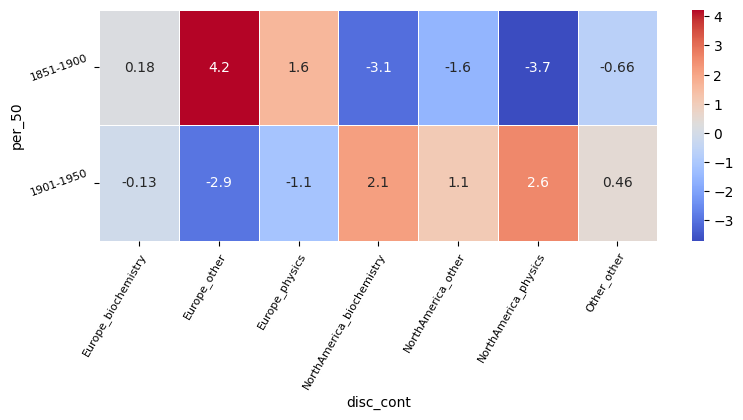

In [116]:
## Appliquer la fonction
bivariee_stats(final_df_filtered)